In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## Data Collection

In [2]:
dataframe = pd.read_csv('./data/akc-data-latest.csv')
dataframe.head()

,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,60.96,71.12,31.751466,58.967008,10.0,13.0,...,0.8,Daily Brushing,0.6,Seasonal,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly


## 1. Data Collection

There was 1 column for the breed name, 1 column with the description, 1 column for a popularity score (1 is the most popular breed, and higher numbers correspond to less popular breeds), and 18 columns for traits.

In [3]:
dataframe.columns.tolist()

['breed',
 'description',
 'temperament',
 'popularity',
 'min_height',
 'max_height',
 'min_weight',
 'max_weight',
 'min_expectancy',
 'max_expectancy',
 'group',
 'grooming_frequency_value',
 'grooming_frequency_category',
 'shedding_value',
 'shedding_category',
 'energy_level_value',
 'energy_level_category',
 'trainability_value',
 'trainability_category',
 'demeanor_value',
 'demeanor_category']

The “min_expectancy” and “max_expectancy” columns refer to the minimum and maximum life expectancies of the dog breed, with years as the unit of measurement.

The “group” column refers to the 7 major dog groups, but there were 2 incorrect values of “Foundation Stock Service” and “Miscellaneous Class”.



In [4]:
dataframe['group'].unique().tolist()


['Toy Group',
 'Hound Group',
 'Terrier Group',
 'Working Group',
 'Foundation Stock Service',
 'Non-Sporting Group',
 'Sporting Group',
 'Herding Group',
 'Miscellaneous Class']

The columns with “_value” in their name have values of 0.2, 0.4, 0.6, 0.8, or 1. that correspond to the values of the columns with “_category” in their name. The higher numbers indicate that the breed has more of the trait that the column refers to. For example, for shedding_value, the higher numbers mean that the breed sheds more often, which is indicated by shedding_category.

In [5]:
dataframe[['shedding_value', 'shedding_category']].head()

,shedding_value,shedding_category
0,0.6,Seasonal
1,0.2,Infrequent
2,0.4,Occasional
3,0.6,Seasonal
4,0.6,Seasonal


## Menampilkan Kolom Temprament
kolom temprament memiliki 129 nilai temprament yang unik, karena itu saya membuat kolom temprament_category untuk mengelompokkan temprament menjadi 10 kategori yang lebih umum yaitu: Friendly, Playful, Loyal, Confident, Intelligent, Gentle, Active, Calm, Indepentend, Brave

In [6]:
temperament_categories = {
    "Amiable": ["Friendly", "Outgoing", "Amiable", "Sociable", "Gregarious"],
    "Playful": ["Playful", "Mischievous", "Fun-Loving", "Lively", "Entertaining", "Energetic"],
    "Loyal": ["Loyal", "Devoted", "Faithful", "Dependable", "Obedient"],
    "Confident": ["Confident", "Self-Confident", "Fearless", "Bold", "Courageous", "Confident Guardian"],
    "Intelligent": ["Very Smart", "Quick", "Intelligent", "Smart", "Observant", "Keenly Observant"],
    "Gentle": ["Gentle", "Sweet-Tempered", "Sweet", "Gentlemanly", "Sweet-Natured"],
    "Active": ["Active", "Spirited", "Keen", "Active", "Vigilant", "Athletic"],
    "Low-Key": ["Calm", "Even-Tempered", "Low-Key"],
    "Independent": ["Independent", "Independent-Minded", "Strong-Willed"],
    "Brave": ["Brave", "Fearless"]
}


In [7]:
# Function to map temperament to the corresponding category
def map_temperament_category(temperament):
    if isinstance(temperament, float):
        return "Other"  # Handle float values
    for category, traits in temperament_categories.items():
        if any(trait in temperament for trait in traits):
            return category
    return "Other"

# Apply the mapping function to the "temperament" column
dataframe["temperament_category"] = dataframe["temperament"].apply(map_temperament_category)


In [8]:
dataframe = dataframe.dropna()
dataframe[['temperament', 'temperament_category']]


,temperament,temperament_category
0,"Confident, Famously Funny, Fearless",Confident
1,"Dignified, Profoundly Loyal, Aristocratic",Loyal
2,"Friendly, Clever, Courageous",Amiable
3,"Courageous, Dignified, Profoundly Loyal",Loyal
4,"Affectionate, Loyal, Playful",Playful
...,...,...
270,"Confident, Alert, Gregarious",Amiable
271,"Friendly, Devoted, Trainable",Amiable
272,"Gentle, Loyal, Trainable",Loyal
274,"Loyal, Alert, Calm",Loyal


## Menampilkan Data Kolom grooming_frequency_category
Grooming frequency mengacu pada seberapa sering suatu hewan peliharaan perlu menjalani perawatan dan pemeliharaan rutin terkait kebersihan dan penampilan fisik mereka. Ini melibatkan kegiatan seperti menyisir bulu, mandi, memotong kuku, pembersihan telinga, dan lain sebagainya.

In [9]:
dataframe['grooming_frequency_category'].unique().tolist()


['2-3 Times a Week Brushing',
 'Daily Brushing',
 'Occasional Bath/Brush',
 'Weekly Brushing',
 'Specialty/Professional']

## Menampilkan Data Kolom shedding_category
Shedding category merujuk pada kategori atau tingkat kehilangan bulu pada hewan peliharaan. Ini menggambarkan seberapa banyak bulu hewan peliharaan rontok secara alami dalam suatu periode waktu tertentu.

In [10]:
dataframe['shedding_category'].unique().tolist()


['Seasonal', 'Infrequent', 'Occasional', 'Regularly', 'Frequent']

## menampilkan data kolom energy_level_category

In [11]:
dataframe['energy_level_category'].unique().tolist()


['Regular Exercise',
 'Energetic',
 'Needs Lots of Activity',
 'Couch Potato',
 'Calm']

## menampilkan data trainability_category

In [12]:
dataframe['trainability_category'].unique().tolist()


['Easy Training',
 'May be Stubborn',
 'Eager to Please',
 'Independent',
 'Agreeable']

## menampilkan data demeanor_category

Demeanor category merujuk pada kategori atau karakteristik perilaku umum yang dimiliki oleh hewan peliharaan. Ini menggambarkan sifat atau sikap umum yang sering terlihat pada hewan peliharaan.

Demeanor category umumnya digunakan untuk menggambarkan sifat atau sikap umum hewan peliharaan, terutama dalam interaksi dengan manusia dan lingkungan sekitarnya.

Temperament category mengacu pada sifat atau sikap bawaan yang mendasar yang cenderung konsisten pada hewan peliharaan sepanjang hidup mereka. Ini adalah sifat-sifat yang melekat pada individu dan cenderung dipengaruhi oleh faktor genetik. Contohnya dapat mencakup tingkat keberanian, keaktifan, kecerdasan, kepatuhan, dan kecenderungan terhadap perilaku tertentu. Temperament category dapat memberikan gambaran umum tentang kepribadian hewan peliharaan.

Sementara itu, demeanor category lebih menggambarkan sikap dan perilaku umum yang sering terlihat pada hewan peliharaan dalam interaksi dengan manusia dan lingkungan sekitarnya. Ini dapat mencakup sifat-sifat seperti ramah, bermain, tenang, protektif, dan mandiri. Demeanor category lebih berfokus pada respons dan perilaku hewan peliharaan terhadap lingkungan sekitarnya dan interaksi dengan pemilik atau orang lain.

Perbedaan utama antara temperament category dan demeanor category adalah bahwa temperament category lebih berkaitan dengan sifat bawaan dan karakteristik individu yang cenderung konsisten, sedangkan demeanor category lebih berkaitan dengan sikap dan perilaku umum yang terlihat dalam interaksi sehari-hari. Dalam konteks hewan peliharaan, keduanya dapat memberikan pemahaman yang lebih lengkap tentang sifat dan perilaku hewan peliharaan tersebut.






In [13]:
dataframe['demeanor_category'].unique().tolist()


['Outgoing',
 'Aloof/Wary',
 'Friendly',
 'Alert/Responsive',
 'Reserved with Strangers']

## Menampilkan Data Kolom Popularity

In [14]:
dataframe['popularity'].tolist()

['148',
 '113',
 '60',
 '47',
 '58',
 '175',
 '122',
 '186',
 '85',
 '166',
 '90',
 '55',
 '17',
 '140',
 'of',
 'of',
 '87',
 '39',
 '6',
 '127',
 '124',
 '43',
 '125',
 '106',
 '187',
 '144',
 '22',
 '46',
 '138',
 '118',
 '49',
 '130',
 '121',
 '35',
 '88',
 '103',
 '21',
 '84',
 '11',
 '100',
 '132',
 '26',
 '98',
 '62',
 '5',
 '51',
 '69',
 '179',
 '32',
 '68',
 '18',
 '185',
 '45',
 '33',
 '79',
 '64',
 '190',
 '75',
 '183',
 '143',
 '30',
 '38',
 '81',
 '162',
 '12',
 '56',
 '176',
 '17',
 '67',
 '52',
 '188',
 '94',
 '27',
 '135',
 '157',
 '149',
 '161',
 '184',
 '91',
 '4',
 '134',
 '2',
 '9',
 '63',
 '174',
 '3',
 '115',
 '177',
 '16',
 '66',
 '74',
 '145',
 '189',
 '24',
 '152',
 '155',
 '77',
 '159',
 '76',
 '73',
 '104',
 '95',
 '173',
 '163',
 '1',
 '99',
 '147',
 '93',
 '71',
 '168',
 '37',
 '133',
 '133',
 '29',
 '34',
 '110',
 '70',
 '19',
 '102',
 '150',
 '40',
 '126',
 '165',
 '97',
 '191',
 '108',
 '83',
 '72',
 '182',
 '54',
 '117',
 '92',
 '13',
 '156',
 '172',
 '

## 2. Data Processing

## Membuat Kolom Height, Weight, dan Expectancy

In [15]:
for col in ['height', 'weight', 'expectancy']:
    dataframe[col] = (dataframe['min_'+col] + dataframe['max_'+col]) / 2

In [16]:
dataframe[['height', 'min_height', 'max_height']].head()

,height,min_height,max_height
0,26.035,22.86,29.21
1,66.040,63.50,68.58
2,58.420,58.42,58.42
3,66.040,60.96,71.12
4,60.960,58.42,63.50


In [17]:
dataframe.head()

,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category,temperament_category,height,weight,expectancy
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing,Confident,26.035,3.855535,13.5
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary,Loyal,66.040,24.947580,13.5
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly,Amiable,58.420,27.215542,12.5
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,60.96,71.12,31.751466,58.967008,10.0,13.0,...,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive,Loyal,66.040,45.359237,11.5
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,...,0.8,Energetic,0.4,Independent,0.8,Friendly,Playful,60.960,36.287390,12.0


In [42]:
dataframe['group'].unique().tolist()

['Toy Group',
 'Hound Group',
 'Terrier Group',
 'Working Group',
 'Non-Sporting Group',
 'Sporting Group',
 'Herding Group']

## Mengkategorisasikan Kolom Height Menjadi 4 Kategori

In [19]:
# Categorize height
dataframe['height_category'] = pd.cut(dataframe['height'],
                                      bins=[0, 30, 50, 70, float('inf')],
                                      labels=['Short', 'Medium', 'Tall', 'Very Tall'])
dataframe['height_category'].unique().tolist()
dataframe['height_category'].value_counts()

Tall         75
Medium       64
Short        38
Very Tall    11
Name: height_category, dtype: int64

In [20]:
## remove 0.0 value from weight column to avoid error
dataframe['weight'].unique().tolist()


[3.855535145000001,
 24.947580350000003,
 27.2155422,
 45.359237,
 36.2873896,
 9.298643585,
 29.48350405,
 15.87573295,
 52.163122550000004,
 19.277675725,
 23.813599425,
 7.937866475,
 19.958064280000002,
 22.6796185,
 10.43262451,
 9.752235955,
 22.679618500000004,
 40.82331330000001,
 27.215542199999998,
 31.978262085,
 41.957294225,
 6.80388555,
 39.689332375000006,
 47.62719885,
 43.09127515,
 28.349523124999997,
 79.37866475000001,
 6.123496995,
 37.421370525,
 8.391458845,
 21.545637575,
 14.741752025,
 35.153408675,
 4.082331330000001,
 20.411656649999998,
 52.16312255,
 20.411656650000005,
 0.0,
 14.288159655000001,
 7.030681735000001,
 8.61825503,
 30.617484975000004,
 2.72155422,
 4.535923700000001,
 31.7514659,
 26.081561275000002,
 31.751465900000007,
 11.33980925,
 5.216312255,
 9.52543977,
 47.400402665000016,
 13.6077711,
 30.617484975,
 4.9895160700000005,
 19.50447191,
 12.020197805,
 12.70058636,
 16.32932532,
 64.636912725,
 51.02914162500001,
 12.473790175000001,


## Mengkategorisasikan Kolom Weight Menjadi 4 Kategori

In [21]:
# Categorize weight
dataframe['weight_category'] = pd.cut(dataframe['weight'],
                                      bins=[0, 10, 30, 50, float('inf')],
                                      labels=['Light', 'Medium', 'Heavy', 'Very Heavy'])
default_weight_category = 'Medium'
dataframe['weight_category'] = dataframe['weight_category'].fillna(default_weight_category)
dataframe['weight_category'].unique().tolist()

# count weight category
dataframe['weight_category'].value_counts()

Medium        94
Light         53
Heavy         30
Very Heavy    11
Name: weight_category, dtype: int64

In [22]:
dataframe['expectancy'].unique().tolist()


[13.5,
 12.5,
 11.5,
 12.0,
 14.0,
 13.0,
 11.0,
 15.0,
 8.5,
 14.5,
 10.0,
 9.0,
 8.0,
 10.5,
 15.5,
 17.0,
 6.5,
 9.5,
 7.0,
 16.0,
 0.0]

## Mengkategorisasikan Kolom Expectancy Menjadi 4 Kategori

In [23]:
# Categorize expectancy
dataframe['expectancy_category'] = pd.cut(dataframe['max_expectancy'],
                                          bins=[0, 5, 10, 15, float('inf')],
                                          labels=['Short', 'Medium', 'Long', 'Very Long'])
dataframe['expectancy_category'] = dataframe['expectancy_category'].fillna('Short')
dataframe['expectancy_category'].unique().tolist()
dataframe['expectancy_category'].value_counts()

Long         146
Very Long     26
Medium        15
Short          1
Name: expectancy_category, dtype: int64

In [24]:
dataframe.dtypes

breed                            object
description                      object
temperament                      object
popularity                       object
min_height                      float64
max_height                      float64
min_weight                      float64
max_weight                      float64
min_expectancy                  float64
max_expectancy                  float64
group                            object
grooming_frequency_value        float64
grooming_frequency_category      object
shedding_value                  float64
shedding_category                object
energy_level_value              float64
energy_level_category            object
trainability_value              float64
trainability_category            object
demeanor_value                  float64
demeanor_category                object
temperament_category             object
height                          float64
weight                          float64
expectancy                      float64


In [25]:
num_classes = len(dataframe['breed'])
print('Number of classes: {}'.format(num_classes))

Number of classes: 188


## 3. Training

In [36]:
# Convert categorical columns to category type
categorical_cols = ['expectancy_category', 'height_category', 'weight_category', 'demeanor_category',
                    'trainability_category', 'energy_level_category', 'shedding_category',
                    'grooming_frequency_category', 'temperament_category']
dataframe[categorical_cols] = dataframe[categorical_cols].astype('category')


# Select the features and target variable
features = ['expectancy_category', 'height_category', 'weight_category', 'demeanor_category',
            'trainability_category', 'energy_level_category', 'shedding_category', 'grooming_frequency_category', 'temperament_category']
target = 'breed'
X = dataframe[features]
y = dataframe[target]

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create feature columns for categorical features
feature_columns = []
for col in categorical_cols:
    vocab = X[col].cat.categories.tolist()
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(col, vocab)
    emb_column = tf.feature_column.embedding_column(cat_column, dimension=8)
    feature_columns.append(emb_column)

# Create input functions for training and evaluation
def input_fn(features, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))
    dataset = dataset.batch(batch_size)
    return dataset

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 8
train_dataset = input_fn(X_train, y_train, batch_size=batch_size)
validation_dataset = input_fn(X_test, y_test, batch_size=batch_size, shuffle=False)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=25)


Train for 19 steps, validate for 5 steps
Epoch 1/25
19/19 [==============================] - 11s 589ms/step - loss: 5.2536 - accuracy: 0.0000e+00 - val_loss: 5.2622 - val_accuracy: 0.0000e+00
Epoch 2/25
19/19 [==============================] - 1s 30ms/step - loss: 5.1941 - accuracy: 0.0067 - val_loss: 5.3154 - val_accuracy: 0.0000e+00
Epoch 3/25
19/19 [==============================] - 0s 17ms/step - loss: 5.1386 - accuracy: 0.0267 - val_loss: 5.4043 - val_accuracy: 0.0000e+00
Epoch 4/25
19/19 [==============================] - 0s 18ms/step - loss: 5.0587 - accuracy: 0.0333 - val_loss: 5.5859 - val_accuracy: 0.0000e+00
Epoch 5/25
19/19 [==============================] - 0s 21ms/step - loss: 4.9397 - accuracy: 0.0467 - val_loss: 5.9097 - val_accuracy: 0.0000e+00
Epoch 6/25
19/19 [==============================] - 0s 19ms/step - loss: 4.7821 - accuracy: 0.0600 - val_loss: 6.3873 - val_accuracy: 0.0000e+00
Epoch 7/25
19/19 [==============================] - 0s 24ms/step - loss: 4.5841 - a

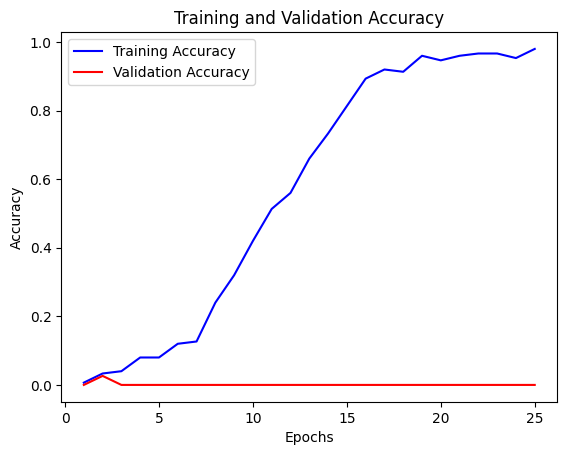

In [33]:
import matplotlib.pyplot as plt

# Get training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# Create a new dataframe with input features for prediction

new_data = pd.DataFrame({
    'expectancy_category': ['Medium'],
    'height_category': ['Tall'],
    'weight_category': ['Medium'],
    'demeanor_category': ['Friendly'],
    'trainability_category': ['Independent'],
    'energy_level_category': ['Energetic'],
    'shedding_category': ['Occasional'],
    'grooming_frequency_category': ['Daily Brushing	'],
    'temperament_category': ['Loyal']
})


# Convert the new data to individual arrays for prediction
new_data_arrays = [new_data[feature].values.reshape(-1, 1) for feature in ['demeanor_category', 'energy_level_category', 'expectancy_category', 'grooming_frequency_category', 'height_category', 'shedding_category', 'trainability_category', 'weight_category', 'temperament_category']]
print(new_data_arrays)

# Make predictions on the new data
predictions = model.predict(new_data_arrays)

# Decode the predicted breed labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_labels)
# Menampilkan hasil prediksi
for label in predicted_labels:
    print(label)


[array([['Friendly']], dtype=object), array([['Energetic']], dtype=object), array([['Medium']], dtype=object), array([['Daily Brushing\t']], dtype=object), array([['Tall']], dtype=object), array([['Occasional']], dtype=object), array([['Independent']], dtype=object), array([['Medium']], dtype=object), array([['Loyal']], dtype=object)]
English Foxhound
